# 3.5. XGBoost

In [15]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# others
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

# 2. Load pandas DataFrame

In [16]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [17]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [18]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')


# Separando el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformando los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')


# Ajustando la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)


df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraer las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unir los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [19]:
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes


df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

df_final = df_final.dropna()

In [20]:
# Cambiar anno, mes, dia, diasem y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

In [21]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_XGB_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_XGB_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] #Weekday is numerical in this case - Intervention variables
INPUTS_XGB = INPUTS_XGB_NUM + INPUTS_XGB_CAT
OUTPUT = 'Utilizacion'

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS_XGB]
y = df_final[OUTPUT]

## Divide the data into training and test sets ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test


In [22]:
len(X_train)

11692

In [23]:
len(X_test)

2924

# 3. Fit the model

In [24]:
# Define los parámetros para XGBoost
param = {'XGB__n_estimators': range(100, 1001, 100),
         'XGB__max_depth': range(3, 10),
         'XGB__learning_rate': [0.01, 0.1, 0.2, 0.3]}

# Prepare los transformadores para datos numéricos y categóricos
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_XGB_NUM),  # Reemplaza INPUTS_RF_NUM por tus columnas numéricas
        ('cat', categorical_transformer, INPUTS_XGB_CAT)  # Reemplaza INPUTS_RF_CAT por tus columnas categóricas
        ])

# Crea el pipeline con XGBoost
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('XGB', XGBRegressor(objective='reg:squarederror', 
                                             random_state=999))])

# Define el número de folds para la validación cruzada y crea el grid search
nFolds = 10
xgb_fit = GridSearchCV(estimator=pipe, 
                      param_grid=param, 
                      scoring='neg_mean_squared_error',
                      n_jobs=-1, 
                      cv=nFolds, 
                      verbose=3)

# Ahora xgb_fit está listo para ser entrenado con xgb_fit.fit(X_train, y_train),
# donde X_train e y_train deben ser tus datos de entrenamiento.


In [25]:
# fit the bagged trees
xgb_fit.fit(X_train[INPUTS_XGB], y_train)

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


[CV 2/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.004 total time=   0.7s
[CV 3/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.004 total time=   0.7s
[CV 1/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.003 total time=   0.7s
[CV 4/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.003 total time=   0.7s
[CV 5/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.004 total time=   0.9s
[CV 7/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.003 total time=   0.8s
[CV 6/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.004 total time=   0.9s
[CV 8/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.003 total time=   0.9s
[CV 10/10] END XGB__learning_rate=0.01, XGB__max_depth=3, XGB__n_estimators=100;, score=-0.003 t

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=999, ...))]),
             n_jobs=-1,
             param_grid={'XGB__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'XGB__max_depth': range(3, 10),
                         'XGB__n_estimators': range(100, 1001, 100)},
             scoring='neg_mean_squared_error', verbose=3)

In [27]:
xgb_fit.best_estimator_['XGB'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 999,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [29]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['RF_pred'] = xgb_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['RF_pred'] = xgb_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred']))

Training MAE: 0.008733136874501158
Test MAE: 0.013398246768767785
Training RMSE: 0.01594945232530506
Test RMSE: 0.02529428384184759
Training R2: 0.9810250008222903
Test R2: 0.9508070755593189


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


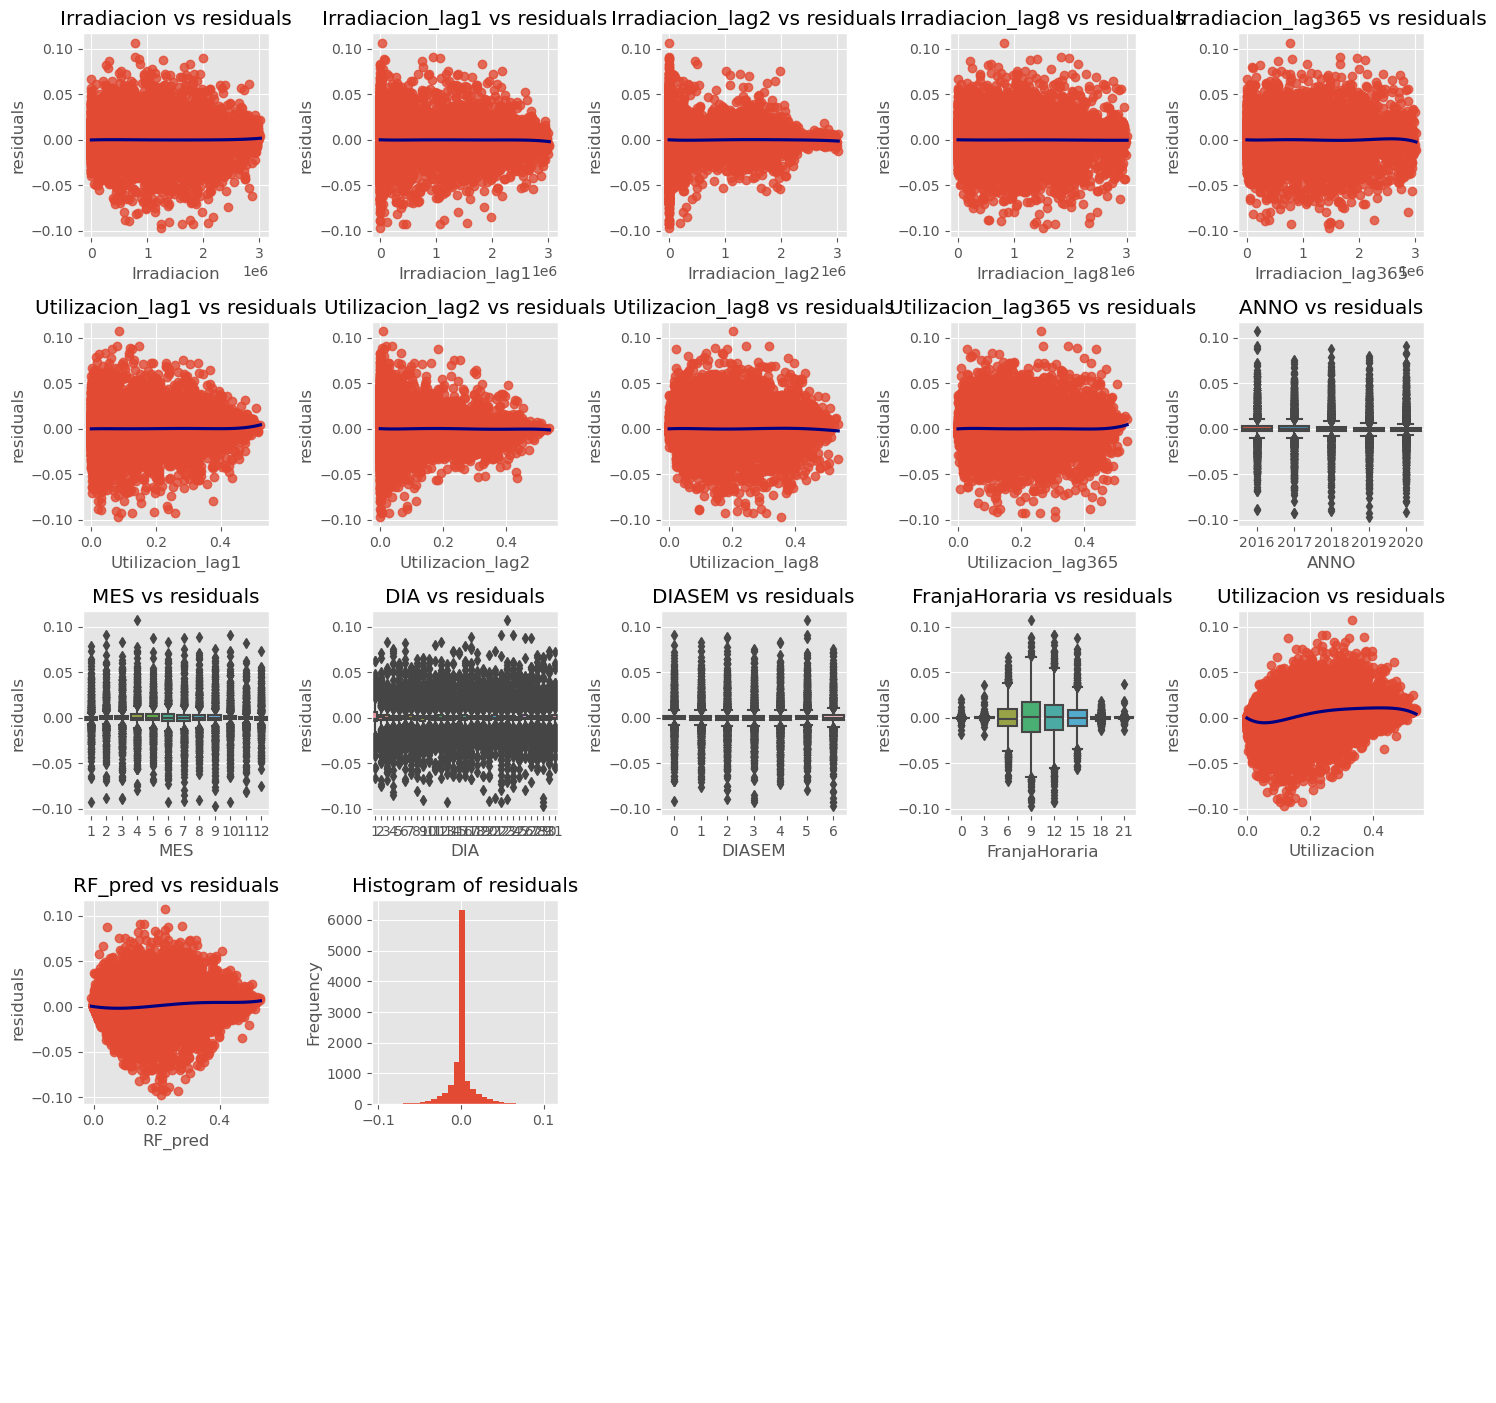

In [30]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'RF_pred', 'Utilizacion', figsize=[15,15])

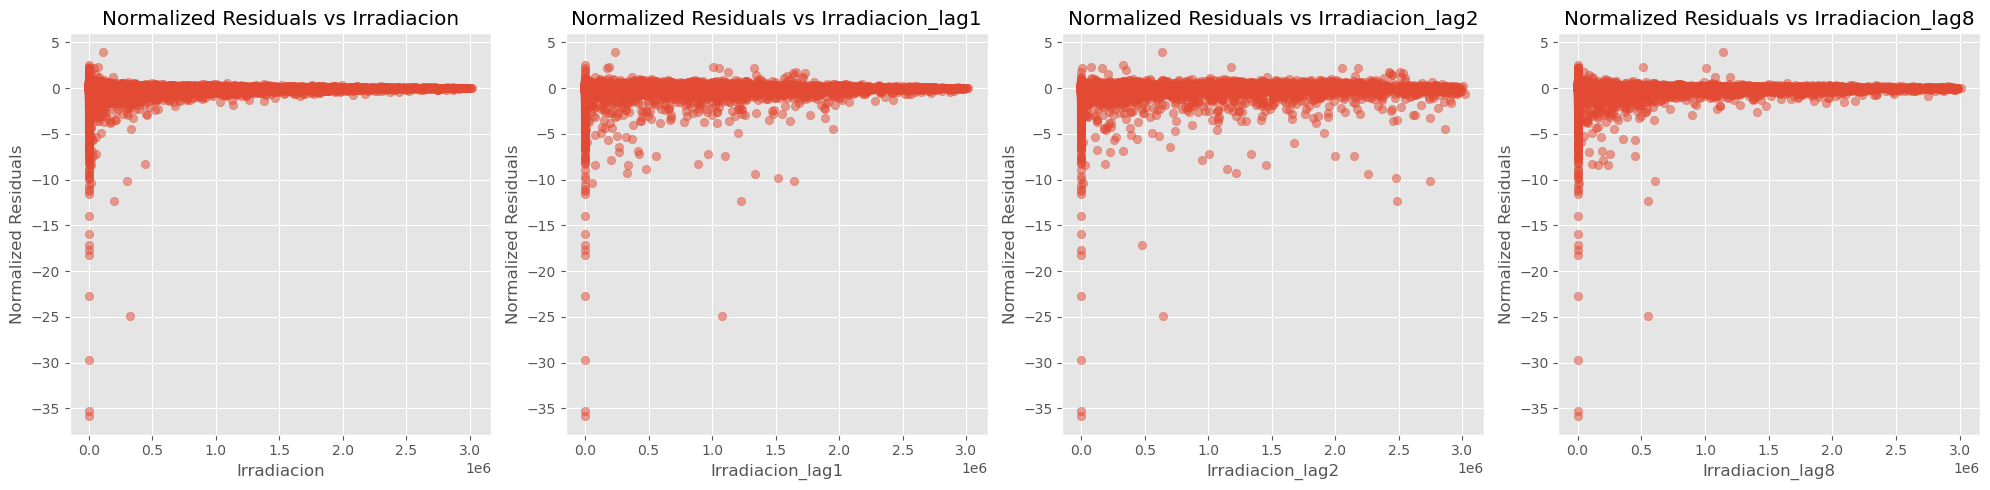

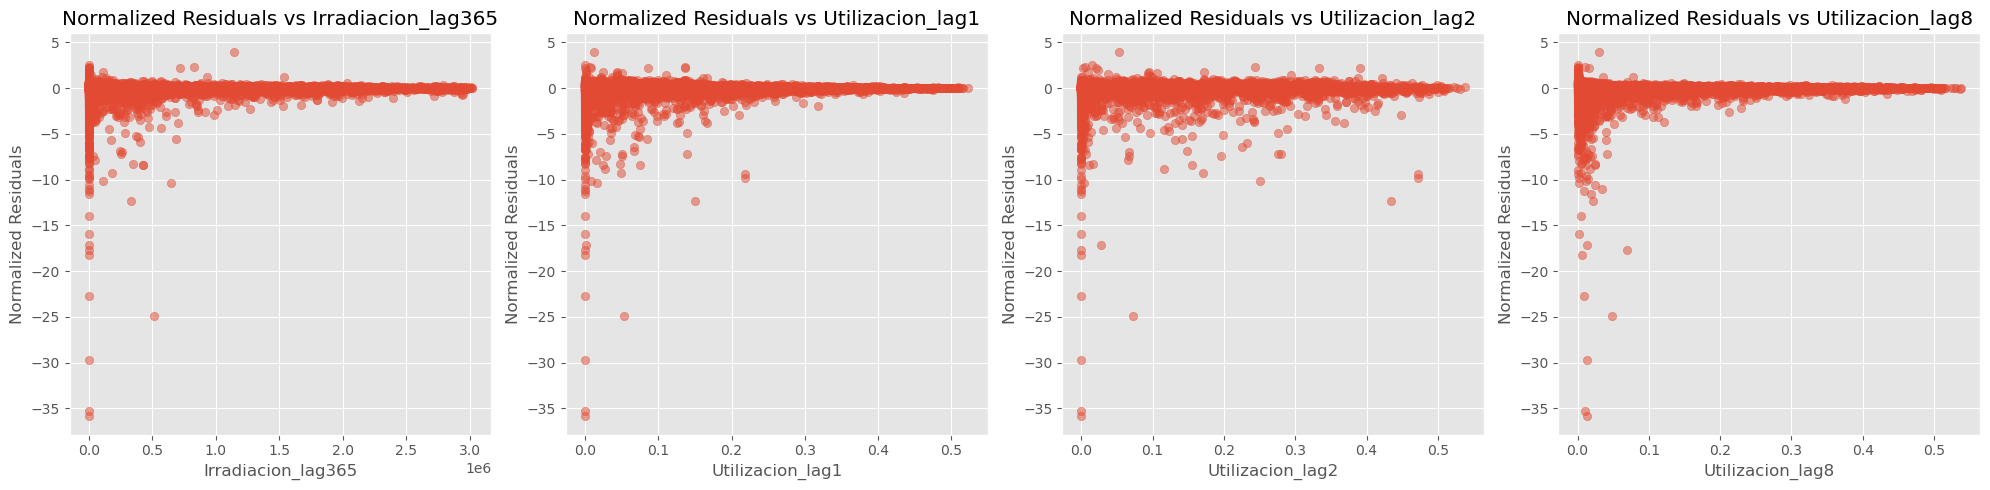

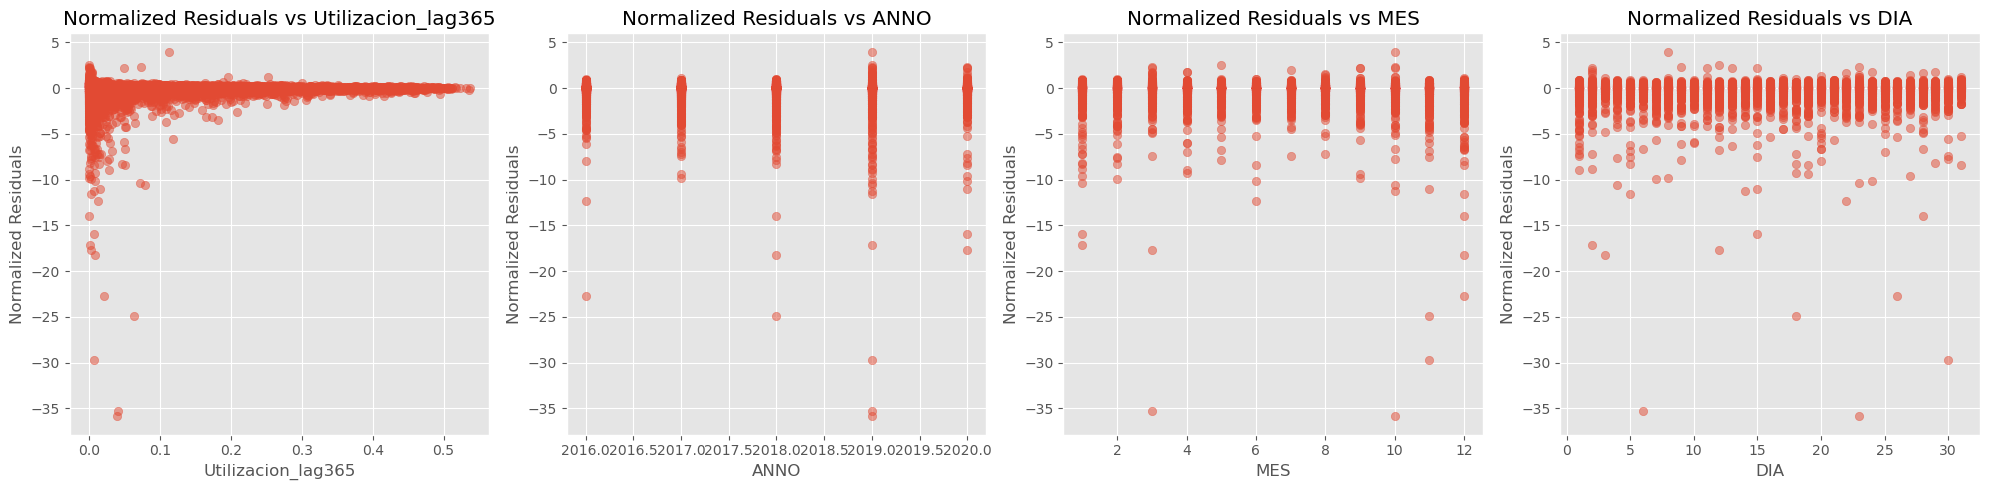

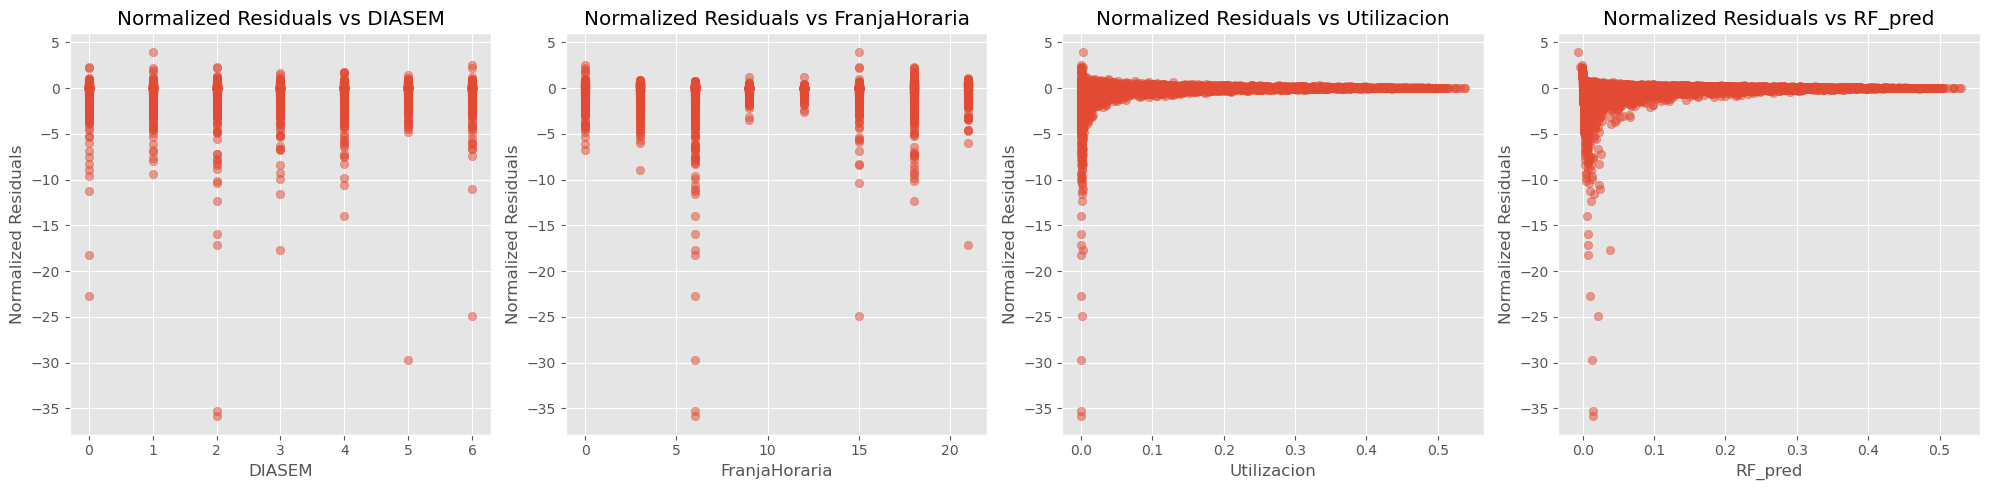

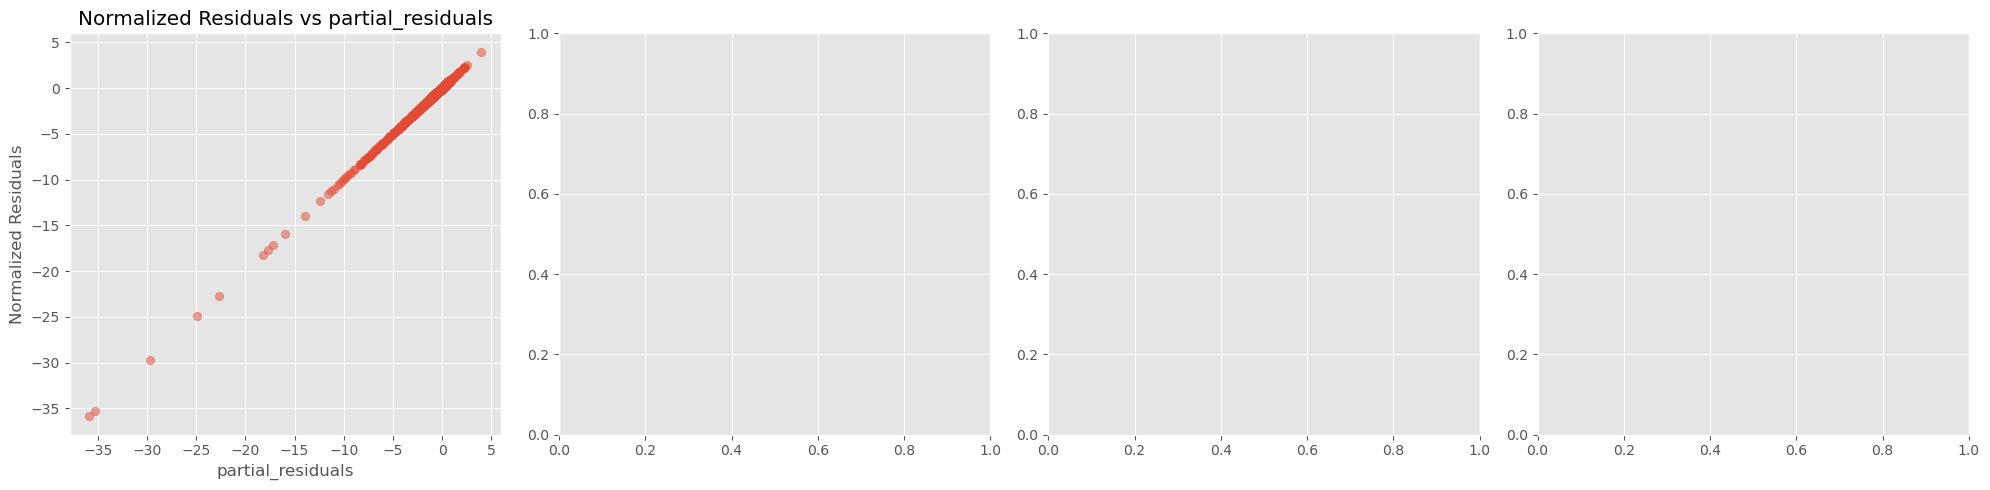

In [32]:
# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()